In [1]:
import pandas as pd
import numpy as np

# Load the processed data
try:
    hybrid_chunks_df = pd.read_pickle('../data/hybrid_chunks_with_embeddings.pkl')
    # allow_pickle=True if embeddings are objects
    full_embeddings_matrix = np.load(
        '../data/full_embeddings_matrix.npy', allow_pickle=True)
    print("Successfully loaded hybrid_chunks_df and full_embeddings_matrix.")
    print(f"hybrid_chunks_df shape: {hybrid_chunks_df.shape}")
    print(f"full_embeddings_matrix shape: {full_embeddings_matrix.shape}")
    display(hybrid_chunks_df.head())
except FileNotFoundError as e:
    print(
        f"Error loading files: {e}. Please ensure the .pkl and .npy files are in the correct path.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Successfully loaded hybrid_chunks_df and full_embeddings_matrix.
hybrid_chunks_df shape: (6434, 18)
full_embeddings_matrix shape: (6434, 768)


,chunk_id,doc_id,doc_name,category,text,chunk_method,level,start_idx,end_idx,document_position,position_score,is_special_section,section_type,level_size,contained_chunks,chunk_relationships,num_words,embedding
0,0,0,AlliedEsportsEntertainmentInc_20190815_8-K_EX-...,License_Agreements,ExhibitJOINT CONTENT LICENSE AGREEMENT This JO...,semantic,L1,0,2782,beginning,0.95,True,definitions,NaN,NaN,"{'same_doc_l1_chunks': [1, 2, 3, 4, 5, 6, 7, 8...",400,"[-0.15306216, 0.17692535, 0.07601996, -0.44562..."
1,1,0,AlliedEsportsEntertainmentInc_20190815_8-K_EX-...,License_Agreements,"respect to the United States are granted to, h...",semantic,L1,2783,5586,beginning,0.85,True,definitions,NaN,NaN,"{'same_doc_l1_chunks': [0, 2, 3, 4, 5, 6, 7, 8...",400,"[-0.030139253, 0.2850941, 0.57376814, 0.084585..."
2,2,0,AlliedEsportsEntertainmentInc_20190815_8-K_EX-...,License_Agreements,"animated, artistic, dramatic, sculptural, musi...",semantic,L1,5587,8324,beginning,0.85,True,definitions,NaN,NaN,"{'same_doc_l1_chunks': [0, 1, 3, 4, 5, 6, 7, 8...",400,"[-0.051381186, 0.17251861, 0.1538294, 0.161512..."
3,3,0,AlliedEsportsEntertainmentInc_20190815_8-K_EX-...,License_Agreements,"specifically described on Exhibit A, for the T...",semantic,L1,8325,10884,beginning,0.85,True,definitions,NaN,NaN,"{'same_doc_l1_chunks': [0, 1, 2, 4, 5, 6, 7, 8...",400,"[-0.09265722, 0.28968588, 0.29306132, -0.43788..."
4,4,0,AlliedEsportsEntertainmentInc_20190815_8-K_EX-...,License_Agreements,to Licensee and rights of approval of Licensor...,semantic,L1,10885,13437,beginning,0.85,True,definitions,NaN,NaN,"{'same_doc_l1_chunks': [0, 1, 2, 3, 5, 6, 7, 8...",400,"[0.056043375, 0.1772994, 0.2049528, -0.1843618..."


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity


# Get unique document IDs
doc_ids = hybrid_chunks_df['doc_id'].unique()

# Initialize similarity matrix
n_docs = len(doc_ids)
doc_similarity_matrix = np.zeros((n_docs, n_docs))

# Calculate mean similarity between documents
for i, doc1_id in enumerate(doc_ids):
    # Get chunks and embeddings for first document
    doc1_chunks = hybrid_chunks_df[hybrid_chunks_df['doc_id'] == doc1_id]
    doc1_embeddings = full_embeddings_matrix[doc1_chunks.index]
    
    for j, doc2_id in enumerate(doc_ids):
        if i == j:
            # Same document - similarity is 1
            doc_similarity_matrix[i, j] = 1.0
            continue
            
        # Get chunks and embeddings for second document
        doc2_chunks = hybrid_chunks_df[hybrid_chunks_df['doc_id'] == doc2_id]
        doc2_embeddings = full_embeddings_matrix[doc2_chunks.index]
        
        # Calculate cosine similarity between all chunks
        similarity_matrix = cosine_similarity(doc1_embeddings, doc2_embeddings)
        
        # Take mean of all chunk similarities
        mean_similarity = np.mean(similarity_matrix)
        doc_similarity_matrix[i, j] = mean_similarity

# Create DataFrame for better visualization using doc_ids as index/columns
similarity_df = pd.DataFrame(
    doc_similarity_matrix,
    index=doc_ids,
    columns=doc_ids
)

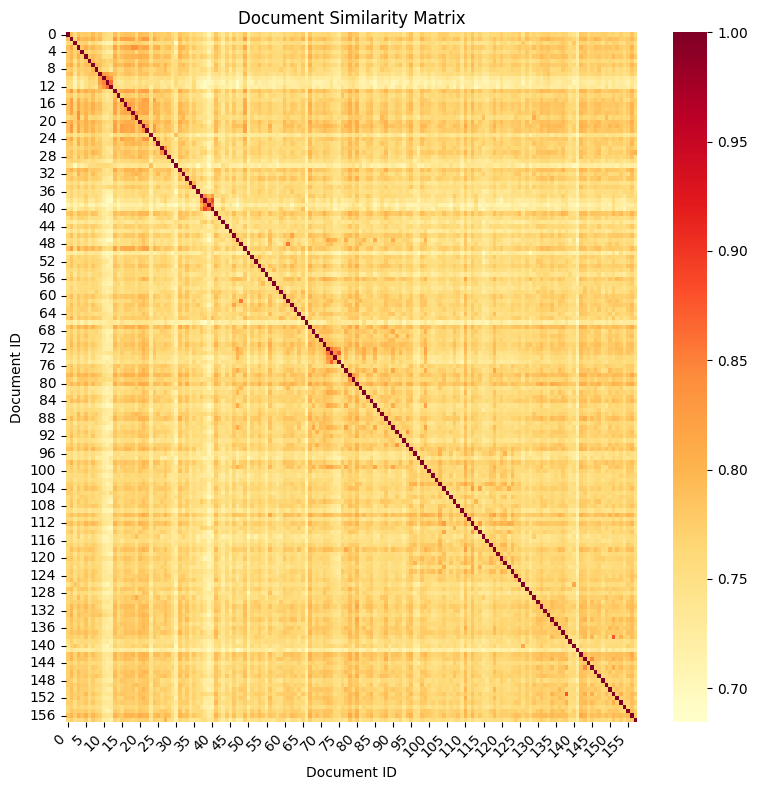

In [7]:
# Plot heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
sns.heatmap(similarity_df, cmap='YlOrRd', fmt='.2f')
plt.title('Document Similarity Matrix')
plt.xlabel('Document ID')
plt.ylabel('Document ID')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


Similarity Distribution Statistics:
Similarity Range  Frequency  Percentage
         0.0-0.1          0        0.00
         0.1-0.2          0        0.00
         0.2-0.3          0        0.00
         0.3-0.4          0        0.00
         0.4-0.5          0        0.00
         0.5-0.6          0        0.00
         0.6-0.7         68        0.27
         0.7-0.8      24228       97.05
         0.8-0.9        510        2.04
         0.9-1.0        158        0.63


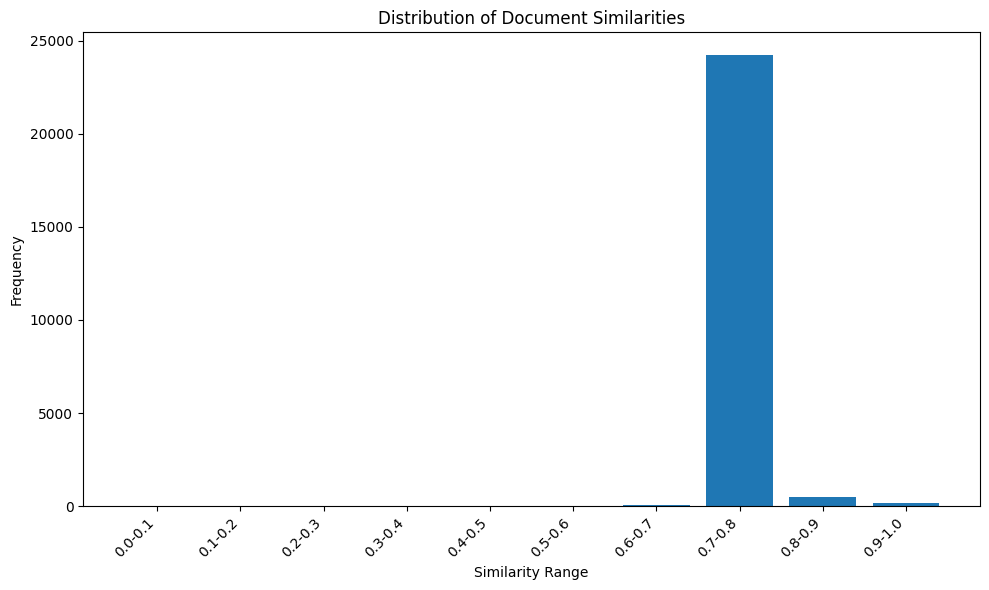


Summary Statistics:
Mean similarity: 0.762
Median similarity: 0.761
Min similarity: 0.684
Max similarity: 1.000
Standard deviation: 0.028


In [8]:
# Get similarity statistics
similarity_values = similarity_df.values.flatten()
similarity_values = similarity_values[~np.isnan(similarity_values)]  # Remove any NaN values

# Calculate frequency of similarity values
bins = np.linspace(0, 1, 11)  # Create 10 bins from 0 to 1
hist, bin_edges = np.histogram(similarity_values, bins=bins)

# Create DataFrame for better visualization
similarity_stats = pd.DataFrame({
    'Similarity Range': [f'{bin_edges[i]:.1f}-{bin_edges[i+1]:.1f}' for i in range(len(bin_edges)-1)],
    'Frequency': hist,
    'Percentage': (hist / len(similarity_values) * 100).round(2)
})

# Display the statistics
print("\nSimilarity Distribution Statistics:")
print(similarity_stats.to_string(index=False))

# Plot histogram
plt.figure(figsize=(10, 6))
plt.bar(similarity_stats['Similarity Range'], similarity_stats['Frequency'])
plt.title('Distribution of Document Similarities')
plt.xlabel('Similarity Range')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print(f"Mean similarity: {similarity_values.mean():.3f}")
print(f"Median similarity: {np.median(similarity_values):.3f}")
print(f"Min similarity: {similarity_values.min():.3f}")
print(f"Max similarity: {similarity_values.max():.3f}")
print(f"Standard deviation: {similarity_values.std():.3f}")